In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [38]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
                 "dog cat animal", "cat animal dog", "cat dog animal"]

In [39]:
flatten = lambda corpus : [word for sublist in corpus for word in sublist.split(" ") ]

In [40]:
vocab = list(set(flatten(corpus)))
vocab

['dog', 'banana', 'cat', 'apple', 'fruit', 'animal']

In [41]:
len(vocab)

6

In [42]:
word2indx = {w:i for i,w in enumerate(vocab,1)}
#append UNK
vocab.append('<UNK>')
word2indx['<UNK>'] = 0

indx2word = {i:w for w,i in word2indx.items()}

In [43]:
word2indx

{'dog': 1,
 'banana': 2,
 'cat': 3,
 'apple': 4,
 'fruit': 5,
 'animal': 6,
 '<UNK>': 0}

In [44]:
indx2word

{1: 'dog',
 2: 'banana',
 3: 'cat',
 4: 'apple',
 5: 'fruit',
 6: 'animal',
 0: '<UNK>'}

In [45]:
from collections import Counter

X_i = Counter(flatten(corpus))
X_i

Counter({'apple': 3, 'banana': 3, 'fruit': 3, 'dog': 3, 'cat': 3, 'animal': 3})

In [46]:
corpus[0]

'apple banana fruit'

In [47]:
corpus =  [sent.split() for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [48]:
skip_grams = []

for doc in corpus:
  for i in range(1, len(doc)-1):
      center = doc[i]
      context = [doc[i-1], doc[i+1]]

      for w in context:
        skip_grams.append((center, w))

skip_grams

[('banana', 'apple'),
 ('banana', 'fruit'),
 ('apple', 'banana'),
 ('apple', 'fruit'),
 ('fruit', 'banana'),
 ('fruit', 'apple'),
 ('cat', 'dog'),
 ('cat', 'animal'),
 ('animal', 'cat'),
 ('animal', 'dog'),
 ('dog', 'cat'),
 ('dog', 'animal')]

In [49]:
X_ik_skipgram =  Counter(skip_grams) # Co-occurece in window size 1
X_ik_skipgram

Counter({('banana', 'apple'): 1,
         ('banana', 'fruit'): 1,
         ('apple', 'banana'): 1,
         ('apple', 'fruit'): 1,
         ('fruit', 'banana'): 1,
         ('fruit', 'apple'): 1,
         ('cat', 'dog'): 1,
         ('cat', 'animal'): 1,
         ('animal', 'cat'): 1,
         ('animal', 'dog'): 1,
         ('dog', 'cat'): 1,
         ('dog', 'animal'): 1})

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

<img src = "image.png" width=400>

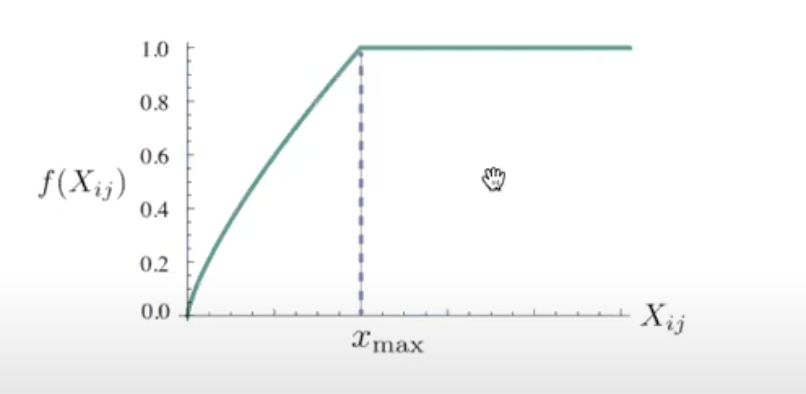

In [50]:
from IPython.display import Image, display

display(Image(filename='image.png'))


In [51]:
def weighting(w_i, w_j, X_ik_skipgram):
  try:
    x_ij = X_ik_skipgram[(w_i, w_j)]
  except:
    x_ij = 1 #if does not exist, set it to 1 ~ "laplace smoothing"


  x_max = 100 # fixed in the paper
  alpha = .75 # recommended in the paper

  return 1 if x_ij >= x_max else (x_ij/x_max)**alpha

In [52]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
  if X_ik_skipgram.get(bigram) is not None:
      co_occer = X_ik_skipgram.get(bigram, 0)
      X_ik[bigram] = co_occer + 1
      X_ik[bigram[1], bigram[0]] = co_occer + 1
  else:
    pass

  weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
  weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

print(f"{X_ik=}")
print(f"{weighting_dic=}")

X_ik={('dog', 'cat'): 2, ('cat', 'dog'): 2, ('dog', 'animal'): 2, ('animal', 'dog'): 2, ('banana', 'apple'): 2, ('apple', 'banana'): 2, ('banana', 'fruit'): 2, ('fruit', 'banana'): 2, ('cat', 'animal'): 2, ('animal', 'cat'): 2, ('apple', 'fruit'): 2, ('fruit', 'apple'): 2}
weighting_dic={('dog', 'dog'): 0.03162277660168379, ('dog', 'banana'): 0.03162277660168379, ('banana', 'dog'): 0.03162277660168379, ('dog', 'cat'): 0.053182958969449884, ('cat', 'dog'): 0.053182958969449884, ('dog', 'apple'): 0.03162277660168379, ('apple', 'dog'): 0.03162277660168379, ('dog', 'fruit'): 0.03162277660168379, ('fruit', 'dog'): 0.03162277660168379, ('dog', 'animal'): 0.053182958969449884, ('animal', 'dog'): 0.053182958969449884, ('dog', '<UNK>'): 0.03162277660168379, ('<UNK>', 'dog'): 0.03162277660168379, ('banana', 'banana'): 0.03162277660168379, ('banana', 'cat'): 0.03162277660168379, ('cat', 'banana'): 0.03162277660168379, ('banana', 'apple'): 0.053182958969449884, ('apple', 'banana'): 0.0531829589694

In [53]:
def random_batch(batch_size, word_sequences, skip_grams, x_ik, weighting_dic):

  skip_grams_ids = [(word2indx[bigram[0]], word2indx[bigram[1]]) for bigram in skip_grams]

  random_inputs, random_labels, random_coocerrence, random_weights= [],[],[],[]


  random_index = np.random.choice(range(len(skip_grams_ids)), batch_size, replace=False)


  for i in random_index:
    random_inputs.append([skip_grams_ids[i][0]])
    random_labels.append([skip_grams_ids[i][1]])

    pair = skip_grams[i]

    try:
      cooc = x_ik[pair]
    except:
      cooc = 1


    random_coocerrence.append([np.log(cooc)])


    random_weights.append([weighting_dic[pair]])

  return np.array(random_inputs), np.array(random_labels), np.array(random_coocerrence), np.array(random_weights)

In [54]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)


print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)


Input:  [[6]
 [2]]
Target:  [[1]
 [4]]
Cooc:  [[0.69314718]
 [0.69314718]]
Weighting:  [[0.05318296]
 [0.05318296]]


## Model

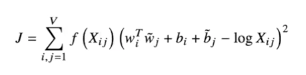

In [55]:
from IPython.display import Image, display

display(Image(filename='image2.png'))

In [56]:
class Glove(nn.Module):
  def __init__(self, vocab_size, embed_size):
    super(Glove, self).__init__()
    self.embedding_v = nn.Embedding(vocab_size, embed_size)
    self.embedding_u = nn.Embedding(vocab_size, embed_size)

    self.v_bias = nn.Embedding(vocab_size, 1)
    self.u_bias = nn.Embedding(vocab_size, 1)

  def forward(self, center_words, target_words, coocs, weighting):
    center_embeds = self.embedding_v(center_words)  # [batch_size, 1, emb_size]
    target_embeds = self.embedding_u(target_words)  # [batch_size, 1, emb_size]

    center_bias = self.v_bias(center_words).squeeze(1)
    target_bias = self.u_bias(center_words).squeeze(1)


    inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
    #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

    #note that coocs already got log
    loss = weighting* torch.pow(inner_product + center_bias + target_bias - coocs, 2)

    return torch.sum(loss)


In [57]:
vocab_size = len(vocab)

In [58]:
batch_size = 10
embed_size = 2
model = Glove(vocab_size, embed_size)

criteron = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)

In [59]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [60]:
import time

num_epochs = 50000


for epoch in range(num_epochs):
  start = time.time()

  input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus,skip_grams,X_ik, weighting_dic)

  input_batch = torch.LongTensor(input_batch)
  target_batch = torch.LongTensor(target_batch)

  cooc_batch =   torch.FloatTensor(cooc_batch)
  weighting_batch =  torch.FloatTensor(weighting_batch)


  loss = model(input_batch, target_batch, cooc_batch, weighting_batch)

  optimizer.zero_grad()
  loss.backward()


  optimizer.step()

  end = time.time()

  epoch_mins, epoch_secs = epoch_time(start, end)

  if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 0.149940 | time: 0m 0s
Epoch: 2000 | cost: 0.001916 | time: 0m 0s
Epoch: 3000 | cost: 0.000005 | time: 0m 0s
Epoch: 4000 | cost: 0.000000 | time: 0m 0s
Epoch: 5000 | cost: 0.000000 | time: 0m 0s
Epoch: 6000 | cost: 0.000000 | time: 0m 0s
Epoch: 7000 | cost: 0.000000 | time: 0m 0s
Epoch: 8000 | cost: 0.000000 | time: 0m 0s
Epoch: 9000 | cost: 0.000000 | time: 0m 0s
Epoch: 10000 | cost: 0.000000 | time: 0m 0s
Epoch: 11000 | cost: 0.000000 | time: 0m 0s
Epoch: 12000 | cost: 0.000000 | time: 0m 0s
Epoch: 13000 | cost: 0.000000 | time: 0m 0s
Epoch: 14000 | cost: 0.000000 | time: 0m 0s
Epoch: 15000 | cost: 0.000000 | time: 0m 0s
Epoch: 16000 | cost: 0.000000 | time: 0m 0s
Epoch: 17000 | cost: 0.000000 | time: 0m 0s
Epoch: 18000 | cost: 0.000000 | time: 0m 0s
Epoch: 19000 | cost: 0.000000 | time: 0m 0s
Epoch: 20000 | cost: 0.000000 | time: 0m 0s
Epoch: 21000 | cost: 0.000000 | time: 0m 0s
Epoch: 22000 | cost: 0.000000 | time: 0m 0s
Epoch: 23000 | cost: 0.000000 | time: 0m 

## 6. Plotting the embeddings

In [61]:
#list of vocabs
vocab[:10]

['dog', 'banana', 'cat', 'apple', 'fruit', 'animal', '<UNK>']

In [62]:
word = vocab[0]

In [63]:
#numericalization
id = word2indx[word]
id

1

In [64]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([1])

In [65]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[1.3071, 0.3115]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.9991, -1.3407]], grad_fn=<EmbeddingBackward0>))

In [66]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-0.5146, grad_fn=<SelectBackward0>)

In [67]:
def get_embed(word):
  id_tensor = torch.LongTensor([word2indx[word]])
  v_embed = model.embedding_v(id_tensor)
  u_embed = model.embedding_u(id_tensor)
  word_embed = (v_embed + u_embed) / 2
  x,y = word_embed[0][0].item(), word_embed[0][1].item()
  return x, y

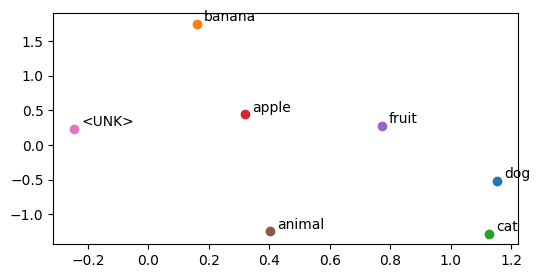

In [68]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [69]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [70]:
vocab

['dog', 'banana', 'cat', 'apple', 'fruit', 'animal', '<UNK>']

In [71]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.3642296069078823
cat vs. animal:  0.9174741921721751
cat vs. cat:  1.0


In [72]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",     cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.3642296069078823
cat vs. animal:  0.9174741921721751
cat vs. cat:  1.0
